In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import cv2
from google.colab.patches import cv2_imshow

In [6]:
mean_gray = 0.1307
stddev_gray = 0.3081

In [7]:
transforms_original = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray,), (stddev_gray))])

transforms_photo = transforms.Compose([transforms.Resize((28, 28)),  transforms.ToTensor(), transforms.Normalize((mean_gray,), (stddev_gray))])

In [8]:
train_dataset = datasets.MNIST(root = "./data", train = True, transform = transforms_original, download = True)

test_dataset = datasets.MNIST(root = "./data", train = False, transform = transforms_original)

100%|██████████| 9912422/9912422 [00:00<00:00, 238955975.63it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112684366.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 60213583.94it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19539003.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



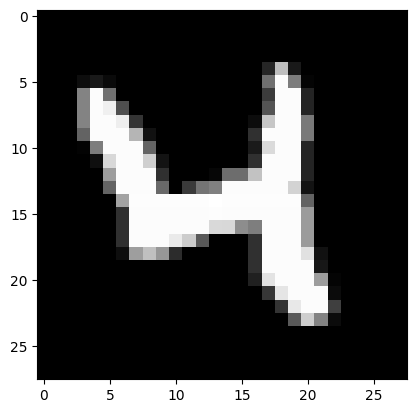

In [9]:
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap = "gray")

In [10]:
print(train_dataset[20][1])

4


In [11]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [12]:
# len(train_dataset / batch_size = len(train_loader
# 60000 / 100 = 600
print("Training Set Images: {}".format(len(train_dataset)))
print("Test Set Images. {}".format(len(test_dataset)))
print("Training Set Batches: {}".format(len(train_loader)))
print("Test Set Batches: {}".format(len(test_loader)))

Training Set Images: 60000
Test Set Images. 10000
Training Set Batches: 600
Test Set Batches: 100


In [13]:
class CNN(nn.Module):

  def __init__(self):

    super(CNN, self).__init__()

    self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.batchnorm1 = nn.BatchNorm2d(8)
    self.relu = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

    self.cnn2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

    # MaxPool dan sonra her feature map 7 (14/2)
    # feature map e flatten uygula
    # 32 feature map var (7x7)
    # 32 * 7 * 7

    self.fc1 = nn.Linear(in_features = 1568, out_features = 600)
    self.dropout = nn.Dropout(p = 0.5)
    self.fc2 = nn.Linear(in_features = 600, out_features = 10)

  def forward(self, x):
    x = self.cnn1(x)
    x = self.batchnorm1(x)
    x = self.relu(x)
    x = self.maxpool1(x)
    x = self.cnn2(x)
    x = self.batchnorm2(x)
    x = self.maxpool2(x)
    x = x.view(-1, 1568)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [14]:
model = CNN()
CUDA = torch.cuda.is_available()

if CUDA:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [15]:
iteration = 0
correct = 0

for i, (inputs, labels) in enumerate(train_loader):

  CUDA = torch.cuda.is_available()

  if CUDA:
    inputs = inputs.cuda()
    labels = labels.cuda()

  print("Her bir iterasyonda ...")
  print("Inputs Shape:", inputs.shape)
  print("Labels Shape:", labels.shape)
  output = model(inputs)
  print("Output Shape:", output.shape)
  _, predicted = torch.max(output, 1)
  print("Predicted Shape:", predicted.shape)
  print("Predicted Tensor:")
  print(predicted)
  correct += (predicted == labels).sum()
  break

Her bir iterasyonda ...
Inputs Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Output Shape: torch.Size([100, 10])
Predicted Shape: torch.Size([100])
Predicted Tensor:
tensor([2, 0, 6, 2, 9, 5, 6, 7, 4, 2, 5, 8, 2, 3, 7, 2, 2, 0, 2, 3, 2, 7, 5, 2,
        4, 2, 4, 7, 7, 3, 3, 3, 2, 5, 3, 1, 2, 3, 5, 2, 7, 2, 2, 0, 7, 6, 1, 5,
        2, 2, 7, 3, 2, 2, 2, 6, 2, 3, 7, 2, 2, 7, 2, 4, 7, 7, 3, 0, 2, 2, 3, 4,
        7, 7, 7, 3, 5, 7, 2, 4, 3, 5, 7, 2, 2, 7, 4, 9, 2, 2, 3, 5, 4, 7, 7, 2,
        3, 2, 4, 2], device='cuda:0')


In [16]:
num_epochs = 25

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):

  correct = 0
  iterations = 0
  iter_loss = 0

  model.train()

  for i, (inputs, labels) in enumerate(train_loader):
    CUDA = torch.cuda.is_available()

    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    iter_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #update the weights

    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
    iterations += 1

  train_loss.append(iter_loss/iterations)
  train_accuracy.append(100*correct/len(train_dataset))

  testing_loss = 0.0
  correct = 0
  iterations = 0

  model.eval() #NN evaluation mode a sok

  for i, (inputs, labels) in enumerate(test_loader):
    CUDA = torch.cuda.is_available()

    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    testing_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
    iterations += 1

  test_loss.append(testing_loss/iterations)
  test_accuracy.append(100*correct/len(test_dataset))

  print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}".format(
epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

Epoch 1/25, Training Loss: 0.417, Training Accuracy: 88.938, Testing Loss: 0.132, Testing Accuracy: 96.470
Epoch 2/25, Training Loss: 0.142, Training Accuracy: 95.988, Testing Loss: 0.087, Testing Accuracy: 97.470
Epoch 3/25, Training Loss: 0.104, Training Accuracy: 96.910, Testing Loss: 0.068, Testing Accuracy: 97.830
Epoch 4/25, Training Loss: 0.085, Training Accuracy: 97.530, Testing Loss: 0.056, Testing Accuracy: 98.150
Epoch 5/25, Training Loss: 0.074, Training Accuracy: 97.880, Testing Loss: 0.053, Testing Accuracy: 98.310
Epoch 6/25, Training Loss: 0.066, Training Accuracy: 98.055, Testing Loss: 0.047, Testing Accuracy: 98.470
Epoch 7/25, Training Loss: 0.059, Training Accuracy: 98.280, Testing Loss: 0.044, Testing Accuracy: 98.550
Epoch 8/25, Training Loss: 0.055, Training Accuracy: 98.400, Testing Loss: 0.041, Testing Accuracy: 98.670
Epoch 9/25, Training Loss: 0.051, Training Accuracy: 98.447, Testing Loss: 0.038, Testing Accuracy: 98.720
Epoch 10/25, Training Loss: 0.047, Tr

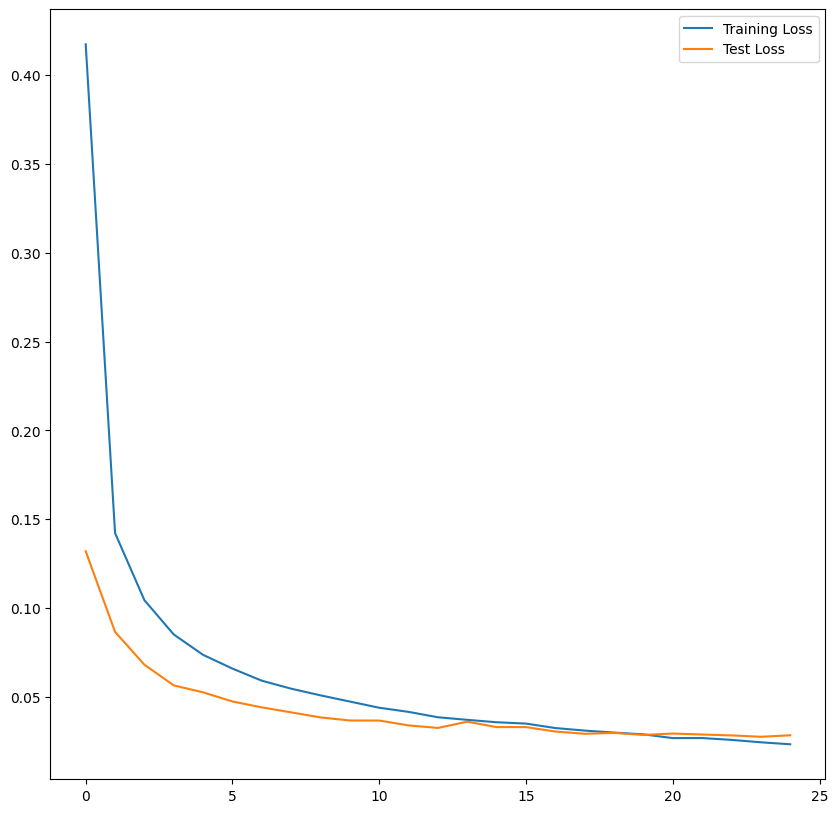

In [17]:
fig = plt.figure(figsize = (10, 10))
plt.plot(train_loss, label = "Training Loss")
plt.plot(test_loss, label = "Test Loss")
plt.legend()
plt.show()

In [19]:
def predict(img_name, model):
  image = cv2.imread(img_name,0)
  ret, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
  img = 255-thresholded
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  img = Image.fromarray(img)
  img = transforms_photo(img)
  img = img.view(1, 1, 28, 28)
  img = Variable(img)

  model.eval()

  if torch.cuda.is_available():
    model = model.cuda()
    img = img.cuda()

  output = model(img)
  print(output)
  print(output.data)
  _, predicted = torch.max(outputs, 1)

  return predicted.item()

In [ ]:
# prediction = predict("ut.png", model)
# print("Tahmin Edilen Label: {}". format(prediction))

Tahmin Edilen Label: 9
Gerçek Label: 9


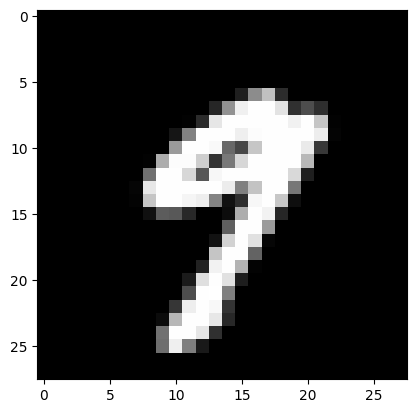

In [25]:
plt.imshow(test_dataset[20][0].reshape(28, 28), cmap = "gray")
img = test_dataset[20][0].resize_((1, 1, 28, 28))
label = test_dataset[20][1]

model.eval()

CUDA = torch.cuda.is_available()

if CUDA:
  model = model.cuda()
  img = img.cuda()

output = model(img)
_, predicted = torch.max(output, 1)

print("Tahmin Edilen Label: {}". format(predicted.item()))
print("Gerçek Label: {}".format(label))